In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

2024-02-26 17:19:47.509322: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 17:19:48.394967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-26 17:19:48.395059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-26 17:19:48.395068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Generate many objects in parallel

ValueError: Must specify num_nyquist_samples if integrating

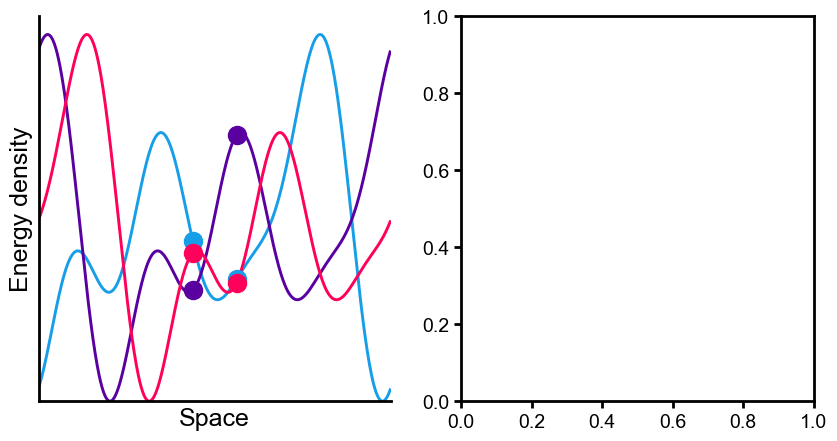

In [2]:
n_objects = 20
num_nyquist_samples = 8
objects = np.array([generate_random_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = signal_from_params(generate_params_of_random_signal(num_nyquist_samples=num_nyquist_samples))
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sampling_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sampling_indices=sampling_indices, plot_signals_in_different_colors=True)

## Show example objects

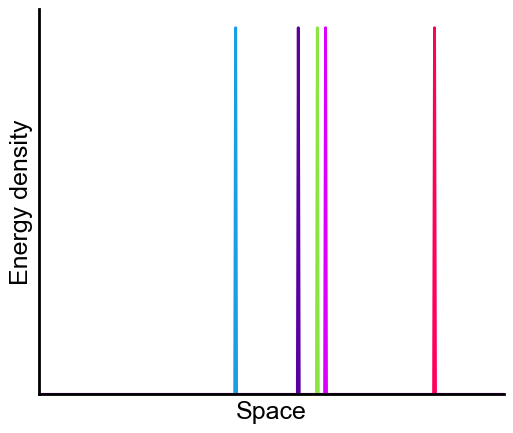

In [3]:
n_objects = 5
objects = np.array([generate_random_object('delta') for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_in_spatial_coordinates(ax, objects)

## Optimize an encoder based on entropy as a loss function

In [4]:
N_objects = 2000
noise_sigma = 1e-4
num_nyquist_samples = 10
sampling_indices = (1, 2)


objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=1) for i in range(N_objects)])

objects = objects_fn()


initial_kernel = generate_random_signal(num_nyquist_samples=num_nyquist_samples)
initial_params = params_from_signal(initial_kernel)

loss_fn = make_convolutional_forward_model_with_mi_loss(objects, noise_sigma)
optimized_params, param_history = run_optimzation(loss_fn, signal_prox_fn, 
                         initial_params, learning_rate=1e-2, learning_rate_decay=0.999, verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(0), return_param_history=True)

initial loss -8.24069371906382


In [5]:
num_objects_to_show = 3

optimized_loss = loss_fn(optimized_params, key=jax.random.PRNGKey(0))

test_objects = objects_fn()

a_few_objects = test_objects[:num_objects_to_show]
output_signals = conv_forward_model(optimized_params, a_few_objects, num_nyquist_samples=num_nyquist_samples)


noise_variance = noise_sigma**2
noise_variance_per_point = (UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples) * noise_variance
